In [1]:
%matplotlib inline

In [2]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(np.__version__)
print(tf.__version__)

1.16.4
2.0.0


In [3]:
# Set random seed
tf.random.set_seed(1)

In [3]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the dataset
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

batch_size = 256

# Create the training database iterator
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size)

Loading data...


In [4]:
# Building model
n_class = 10
input_dim = 784
z_dim = 2


# Encoder
def make_encoder_model():
    inputs = tf.keras.Input(shape=(input_dim,), name='Original_input')
    x = tf.keras.layers.Dense(500, activation='relu')(inputs)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    latent = tf.keras.layers.Dense(z_dim, activation='linear', name='Latent_variables')(x)
    observed = tf.keras.layers.Dense(n_class, activation='softmax', name='Observed_variables')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[latent, observed], name='Encoder')
    return model


encoder = make_encoder_model()

In [ ]:
encoder.summary()

In [5]:
# Decoder
def make_decoder_model():
    inputted_latent = tf.keras.Input(shape=(z_dim,), name='Latent_variables')
    inputted_observed = tf.keras.Input(shape=(n_class,), name='Observed_variables')

    x = tf.keras.layers.concatenate([inputted_latent, inputted_observed], axis=-1)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    reconstruction = tf.keras.layers.Dense(input_dim, activation='linear', name='Reconstruction')(x)
    model = tf.keras.Model(inputs=[inputted_latent, inputted_observed], outputs=reconstruction, name='Decoder')
    return model


decoder = make_decoder_model()

In [ ]:
decoder.summary()

In [6]:
# Multipliers
alpha = 100.0
beta = 10.0
gamma = 10.0

# Loss functions
# Reconstruction cost
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Supervised cost
cat_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [7]:
# Unsupervised cross-covariance cost
def xcov_loss_fn(latent, observed, batch_size):
    latent_centered = latent - tf.reduce_mean(latent, axis=0, keepdims=True)
    observed_centered = observed - tf.reduce_mean(observed, axis=0, keepdims=True)
    xcov_loss = 0.5 * tf.reduce_sum(
        tf.square(tf.matmul(latent_centered, observed_centered, transpose_a=True) / batch_size))

    return xcov_loss

In [8]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [9]:
# Training step
@tf.function
def train_on_batch(batch_x, batch_y):
    with tf.GradientTape() as tape:
        # Inference
        batch_latent, batch_observed = encoder(batch_x)
        batch_reconstruction = decoder([batch_latent, batch_observed])

        # Loss functions
        recon_loss = alpha * mse_loss_fn(batch_x, batch_reconstruction)
        cat_loss = beta * cat_loss_fn(tf.one_hot(batch_y, n_class), batch_observed)
        xcov_loss = gamma * xcov_loss_fn(batch_latent, batch_observed, tf.cast(tf.shape(batch_x)[0], tf.float32))

        # Final loss function
        ae_loss = recon_loss + cat_loss + xcov_loss

    gradients = tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return recon_loss, cat_loss, xcov_loss

In [82]:
n_epochs = 200
for epoch in range(n_epochs):
    start = time.time()

    # Functions to calculate epoch's mean performance
    epoch_recon_loss_avg = tf.metrics.Mean()
    epoch_cat_loss_avg = tf.metrics.Mean()
    epoch_xcov_loss_avg = tf.metrics.Mean()

    for batch, (batch_x, batch_y) in enumerate(train_dataset):
        recon_loss, cat_loss, xcov_loss = train_on_batch(batch_x, batch_y)

        epoch_recon_loss_avg(recon_loss)
        epoch_cat_loss_avg(cat_loss)
        epoch_xcov_loss_avg(xcov_loss)

    epoch_time = time.time() - start
    print('{:3d}: {:.2f}s ETA: {:.2f}s  Reconstruction cost: {:.4f}  Supervised cost: {:.4f}  XCov cost: {:.4f}'
          .format(epoch + 1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_recon_loss_avg.result(),
                  epoch_cat_loss_avg.result(),
                  epoch_xcov_loss_avg.result()))


  1: 21.37s ETA: 4273.79s  Reconstruction cost: 3.2249  Supervised cost: 0.0058  XCov cost: 0.0130
  2: 3.42s ETA: 679.94s  Reconstruction cost: 3.2228  Supervised cost: 0.0060  XCov cost: 0.0127
  3: 3.19s ETA: 631.82s  Reconstruction cost: 3.2218  Supervised cost: 0.0059  XCov cost: 0.0124
  4: 2.92s ETA: 574.69s  Reconstruction cost: 3.2206  Supervised cost: 0.0058  XCov cost: 0.0126
  5: 3.10s ETA: 607.76s  Reconstruction cost: 3.2170  Supervised cost: 0.0057  XCov cost: 0.0123
  6: 2.89s ETA: 564.03s  Reconstruction cost: 3.2141  Supervised cost: 0.0058  XCov cost: 0.0122
  7: 3.09s ETA: 599.56s  Reconstruction cost: 3.2147  Supervised cost: 0.0054  XCov cost: 0.0120
  8: 2.88s ETA: 555.06s  Reconstruction cost: 3.2110  Supervised cost: 0.0061  XCov cost: 0.0124
  9: 2.83s ETA: 543.88s  Reconstruction cost: 3.2101  Supervised cost: 0.0055  XCov cost: 0.0119
 10: 2.82s ETA: 537.69s  Reconstruction cost: 3.2068  Supervised cost: 0.0056  XCov cost: 0.0122
 11: 2.81s ETA: 534.83s  Rec

 86: 2.94s ETA: 337.84s  Reconstruction cost: 3.0958  Supervised cost: 0.0056  XCov cost: 0.0092
 87: 3.05s ETA: 347.95s  Reconstruction cost: 3.0972  Supervised cost: 0.0058  XCov cost: 0.0094
 88: 3.08s ETA: 348.04s  Reconstruction cost: 3.0933  Supervised cost: 0.0057  XCov cost: 0.0092
 89: 3.09s ETA: 345.73s  Reconstruction cost: 3.0940  Supervised cost: 0.0059  XCov cost: 0.0091
 90: 3.13s ETA: 347.18s  Reconstruction cost: 3.0901  Supervised cost: 0.0057  XCov cost: 0.0092
 91: 2.96s ETA: 325.97s  Reconstruction cost: 3.0907  Supervised cost: 0.0058  XCov cost: 0.0091
 92: 2.94s ETA: 320.52s  Reconstruction cost: 3.0901  Supervised cost: 0.0060  XCov cost: 0.0092
 93: 3.03s ETA: 327.41s  Reconstruction cost: 3.0892  Supervised cost: 0.0059  XCov cost: 0.0088
 94: 3.10s ETA: 331.40s  Reconstruction cost: 3.0870  Supervised cost: 0.0058  XCov cost: 0.0092
 95: 3.11s ETA: 330.11s  Reconstruction cost: 3.0854  Supervised cost: 0.0060  XCov cost: 0.0092
 96: 3.10s ETA: 325.51s  Recon

171: 2.89s ETA: 86.74s  Reconstruction cost: 3.0115  Supervised cost: 0.0074  XCov cost: 0.0078
172: 2.90s ETA: 84.14s  Reconstruction cost: 3.0101  Supervised cost: 0.0074  XCov cost: 0.0080
173: 2.90s ETA: 81.25s  Reconstruction cost: 3.0056  Supervised cost: 0.0075  XCov cost: 0.0080
174: 2.90s ETA: 78.28s  Reconstruction cost: 3.0062  Supervised cost: 0.0073  XCov cost: 0.0080
175: 2.90s ETA: 75.49s  Reconstruction cost: 3.0088  Supervised cost: 0.0075  XCov cost: 0.0078
176: 2.91s ETA: 72.65s  Reconstruction cost: 3.0050  Supervised cost: 0.0075  XCov cost: 0.0077
177: 2.92s ETA: 69.98s  Reconstruction cost: 3.0067  Supervised cost: 0.0078  XCov cost: 0.0079
178: 2.89s ETA: 66.50s  Reconstruction cost: 3.0025  Supervised cost: 0.0075  XCov cost: 0.0078
179: 2.90s ETA: 63.84s  Reconstruction cost: 3.0053  Supervised cost: 0.0075  XCov cost: 0.0081
180: 2.90s ETA: 60.80s  Reconstruction cost: 3.0004  Supervised cost: 0.0076  XCov cost: 0.0079
181: 2.91s ETA: 58.15s  Reconstruction c

In [83]:
acc_fn = tf.keras.metrics.CategoricalAccuracy()

z_test, observed_test = encoder(x_test)
acc_test = acc_fn(tf.one_hot(y_test, n_class), observed_test)

print('Test set accuracy: {:.2f}'.format(100 * acc_test))

Test set accuracy: 97.95


In [84]:
n_class=10
tf.one_hot(ys, n_class)

<tf.Tensor: id=1852643, shape=(90, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       

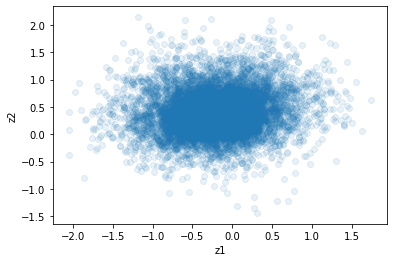

In [85]:
# Figure 3a
plt.figure()
plt.xlabel('z1')
plt.ylabel('z2')
plt.scatter(z_test.numpy()[:, 1], z_test.numpy()[:, 0], alpha=0.1)
plt.show()

In [33]:
np.max(z_test)

0.70853984

In [86]:
# Figure 3b and c
ys = np.repeat(np.arange(10), 9).astype('int32')
#array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       #2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       #4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
       #7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       #9, 9])

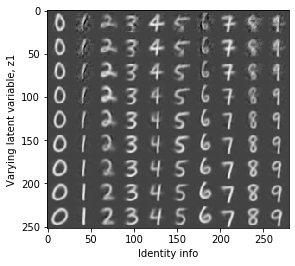

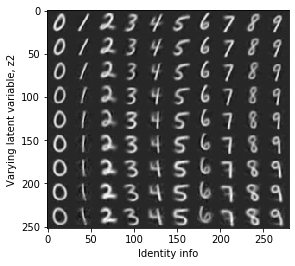

In [87]:
zs = np.tile(np.linspace(-0.5, 0.5, 9), 10).astype('float32')
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T


reconstructions_z1 = decoder([z1s, tf.one_hot(ys, n_class)]).numpy()
reconstructions_z2 = decoder([z2s, tf.one_hot(ys, n_class)]).numpy()

im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.xlabel('Identity info')
plt.ylabel('Varying latent variable, z1')
plt.show()

im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.xlabel('Identity info')
plt.ylabel('Varying latent variable, z2')
plt.show()

In [ ]:
zs = np.tile(np.linspace(-0.6, 0.6, 9), 10).astype('float32')
z1s = np.vstack([np.zeros_like(zs),  np.zeros_like(zs), np.zeros_like(zs), np.zeros_like(zs),zs]).T
# z2s = np.vstack([np.zeros_like(zs), zs]).T

reconstructions_z1 = decoder([z1s, tf.one_hot(ys, n_class)]).numpy()
# reconstructions_z2 = decoder([z2s, tf.one_hot(ys, n_class)]).numpy()

im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.xlabel('Identity info')
plt.ylabel('Varying latent variable, z1')
plt.show()

# im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
# plt.imshow(im2, cmap=plt.cm.gray)
# plt.xlabel('Identity info')
# plt.ylabel('Varying latent variable, z2')
# plt.show()

In [ ]:
tf.one_hot(ys, n_class)[0]

In [ ]:
c=np.array([0,-0.5])
c.dtype

Text(0.5, 1.0, '0 which has high width')

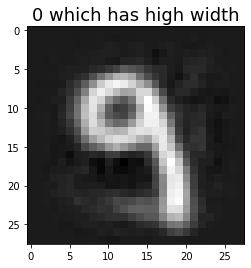

In [221]:
a=np.array([[0.0,0.5]]).astype('float32')
b=np.array([[0,0,0,0,0,0,0,0,0,1]]).astype('float32')
reconstructions_z1 = decoder([a,b]).numpy()
im_9=reconstructions_z1.reshape(28,28)
fig=plt.figure(figsize=(4,4))
plt.imshow(im_9,cmap='gray')
plt.title('0 which has high width', fontsize=18)

Text(0.5, 1.0, '9 which has less width')

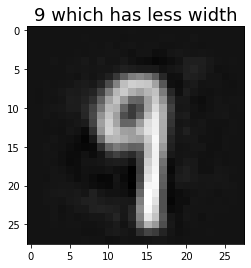

In [209]:
a=np.array([[-0.0,0.0]]).astype('float32')
b=np.array([[0,0,0,0,0,0,0,0,0,1]]).astype('float32')
reconstructions_z1 = decoder([a,b]).numpy()
im_9=reconstructions_z1.reshape(28,28)
fig=plt.figure(figsize=(4,4))
plt.imshow(im_1,cmap='gray')
plt.title('9 which has less width', fontsize=18)

In [159]:
im_5 = im_5.reshape((-1, 28 * 28))

In [227]:
im_5 = im_5.reshape(28,28)

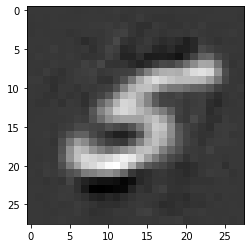

In [208]:
plt.imshow(im_5.reshape(28,28),cmap='gray')

In [222]:
batch_latent_5, batch_observed_5 = encoder(im_5.reshape((-1,28*28)))

In [223]:
batch_latent_9, batch_observed_9 = encoder(im_9.reshape((-1,28*28)))

Text(0.5, 1.0, '0 with reduced width')

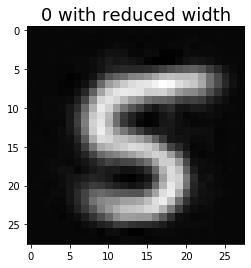

In [224]:
reconstructions_z1 = decoder([batch_latent_9,batch_observed_5]).numpy()
im_recon_5=reconstructions_z1.reshape(28,28)
fig=plt.figure(figsize=(4,4))
plt.imshow(im_recon_5,cmap='gray')
plt.title('0 with reduced width', fontsize=18)

Text(0.5, 1.0, '9 with increased width')

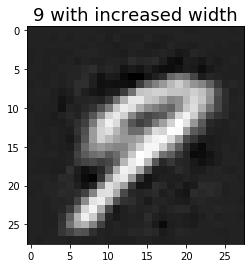

In [225]:
reconstructions_z1 = decoder([batch_latent_5,batch_observed_9]).numpy()
im_recon_9=reconstructions_z1.reshape(28,28)
fig=plt.figure(figsize=(4,4))
plt.imshow(im_recon_9,cmap='gray')
plt.title('9 with increased width', fontsize=18)

In [74]:
batch_latent_5

<tf.Tensor: id=619244, shape=(1, 2), dtype=float32, numpy=array([[-0.17472798, -2.1574159 ]], dtype=float32)>

In [199]:
fig = plt.figure()
fig.add_subplot()

/home/chaitra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '9 which got rotated to right')

<Figure size 432x288 with 0 Axes>

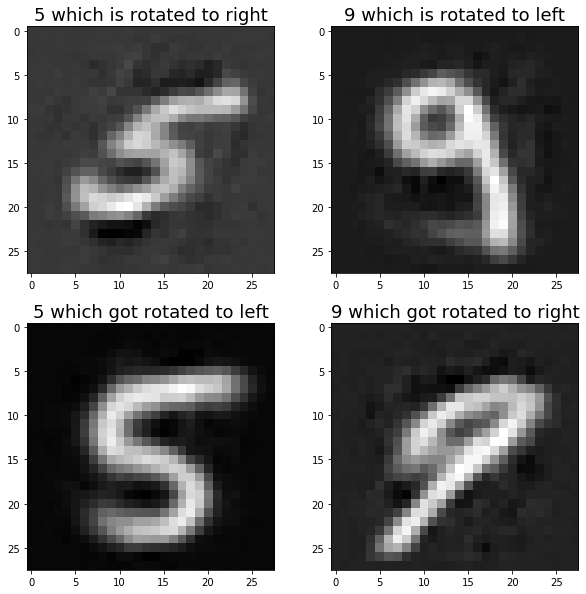

In [229]:
fig = plt.figure()
fig=plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(im_5,cmap='gray')
plt.title('5 which is rotated to right', fontsize=18)
plt.subplot(222)
plt.imshow(im_9,cmap='gray')
plt.title('9 which is rotated to left', fontsize=18)
plt.subplot(223)
plt.imshow(im_recon_5,cmap='gray')
plt.title('5 which got rotated to left', fontsize=18)
plt.subplot(224)
plt.imshow(im_recon_9,cmap='gray')
plt.title('9 which got rotated to right', fontsize=18)

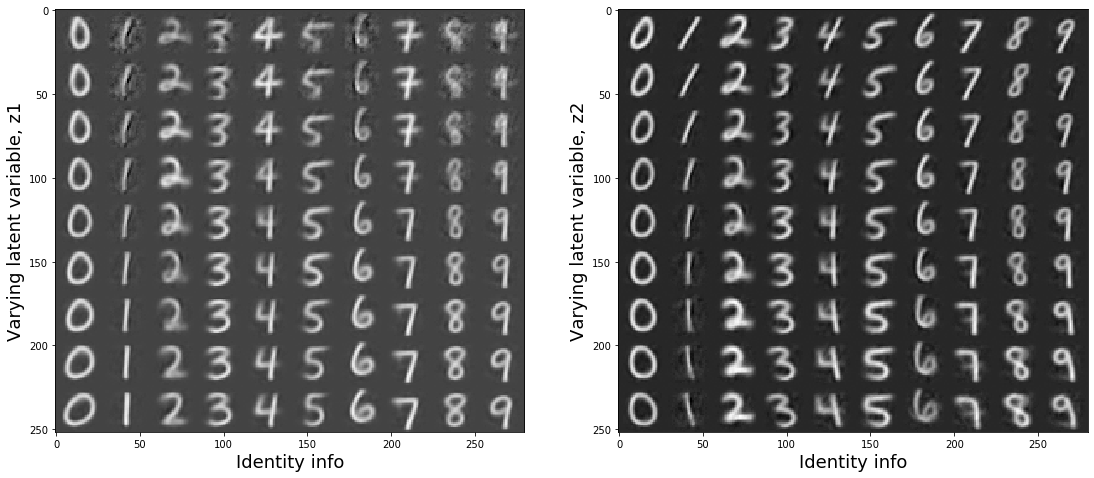

In [91]:

# plt.xlabel('Identity info')
# plt.ylabel('Varying latent variable, z1')
# plt.show()


# plt.imshow(im2, cmap=plt.cm.gray)
# plt.xlabel('Identity info')
# plt.ylabel('Varying latent variable, z2')
# plt.show()
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(121)
plt.xlabel('Identity info',fontsize=18)
plt.ylabel('Varying latent variable, z1',fontsize=18)
plt.imshow(im1,cmap='gray')
plt.subplot(122)
plt.xlabel('Identity info',fontsize=18)
plt.ylabel('Varying latent variable, z2',fontsize=18)
plt.imshow(im2,cmap='gray')
plt.show()